<center><h1>Time Series</h1></center>

# 1. Information

Data Set Information:

Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.


Attribute Information:

holiday Categorical US National holidays plus regional holiday, Minnesota State Fair
temp Numeric Average temp in kelvin
rain_1h Numeric Amount in mm of rain that occurred in the hour
snow_1h Numeric Amount in mm of snow that occurred in the hour
clouds_all Numeric Percentage of cloud cover
weather_main Categorical Short textual description of the current weather
weather_description Categorical Longer textual description of the current weather
date_time DateTime Hour of the data collected in local CST time
traffic_volume Numeric Hourly I-94 ATR 301 reported westbound traffic volume

# 2. Fetching Data:

## 2.1 Import packages

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
import warnings
import math

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

## 2.2 Import data

In [2]:
df=pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

In [3]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
df.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


# 3. Data Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
holiday                48204 non-null object
temp                   48204 non-null float64
rain_1h                48204 non-null float64
snow_1h                48204 non-null float64
clouds_all             48204 non-null int64
weather_main           48204 non-null object
weather_description    48204 non-null object
date_time              48204 non-null object
traffic_volume         48204 non-null int64
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [6]:
df.isna().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

In [7]:
data = df[['traffic_volume','date_time','holiday', 'temp']].copy()

In [8]:
data.date_time = data.date_time.apply(lambda x: pd.to_datetime(x))

In [9]:
data.drop_duplicates(subset = ['date_time'], inplace = True)#, ignore_index = True
data.reset_index(inplace=True, drop=True)

In [10]:
data.date_time.duplicated().sum()

0

In [11]:
data.head()

,traffic_volume,date_time,holiday,temp
0,5545,2012-10-02 09:00:00,None,288.28
1,4516,2012-10-02 10:00:00,None,289.36
2,4767,2012-10-02 11:00:00,None,289.58
3,5026,2012-10-02 12:00:00,None,290.13
4,4918,2012-10-02 13:00:00,None,291.14


In [12]:
data.date_time=data.date_time.apply(lambda x: pd.to_datetime(x))

In [13]:
data=data.set_index('date_time')

Интерполируем данные

In [14]:
data = data.resample('H').asfreq()

In [15]:
data = data.interpolate(limit=4)

Выкидываем день если по целому дню нт информации

In [16]:
data.dropna(inplace=True)
data.head()

,traffic_volume,holiday,temp
date_time,,,
2012-10-02 09:00:00,5545.0,None,288.28
2012-10-02 10:00:00,4516.0,None,289.36
2012-10-02 11:00:00,4767.0,None,289.58
2012-10-02 12:00:00,5026.0,None,290.13
2012-10-02 13:00:00,4918.0,None,291.14


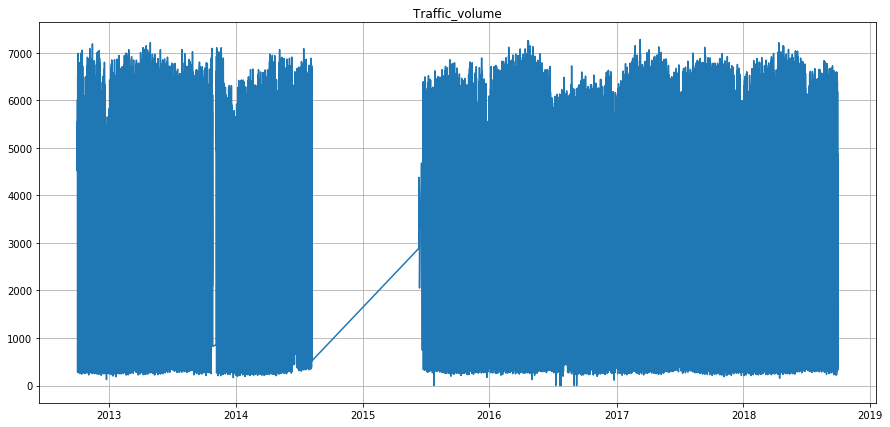

In [17]:
plt.figure(figsize=(15, 7))
plt.plot(data.traffic_volume)
plt.title('Traffic_volume')
plt.grid(True)
plt.show()

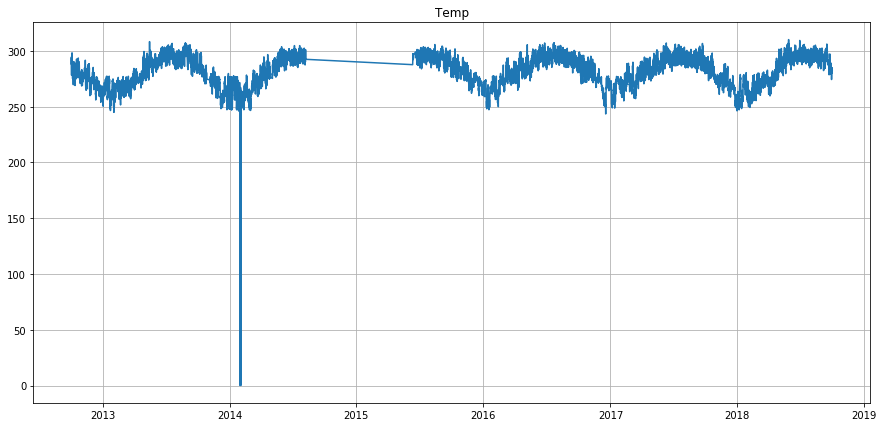

In [18]:
plt.figure(figsize=(15, 7))
plt.plot(data.temp)
plt.title('Temp')
plt.grid(True)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C41F548>,
      dtype=object)

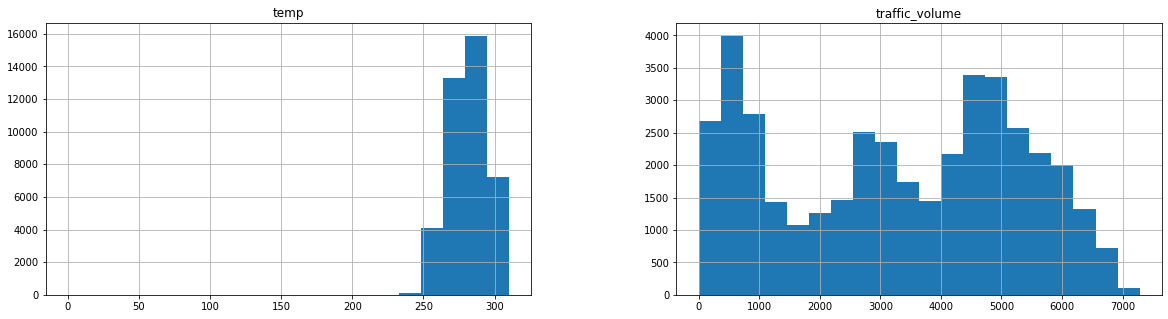

In [19]:
data[['temp','traffic_volume']].hist(figsize=(20,5), bins=20)

Визуализация тренда

In [20]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [21]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        #plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

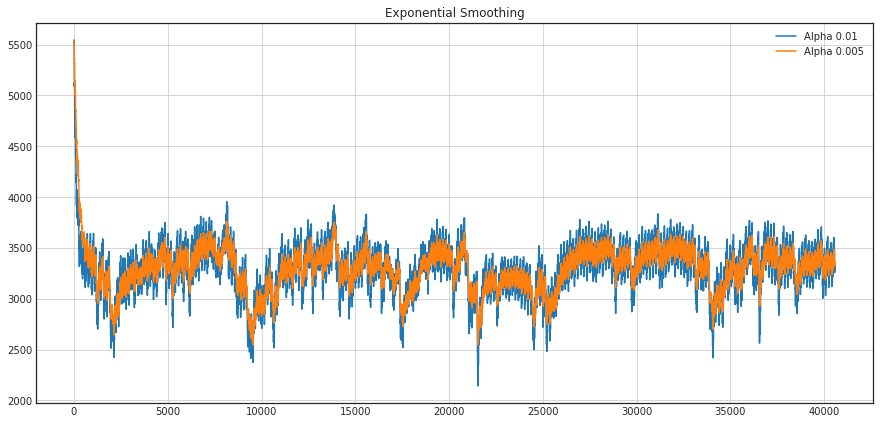

In [22]:
#data_ml[['traffic_volume']]
plotExponentialSmoothing(data.traffic_volume, [0.01, 0.005])

In [23]:
data_ml = data[data.tail(365*3*24).index[0]:].copy()

In [24]:
data_ml.isna().sum()

traffic_volume    0
holiday           0
temp              0
dtype: int64

Устанавливаем праздничные дни на весь день.

In [25]:
data_ml.holiday = data_ml.holiday.apply(lambda x: 0 if (x=='None') or pd.isna(x) else 1)

In [26]:
# Set hoiday all day
for i in data_ml.index:
    if (data_ml[str(i):str(i)].holiday[0] == 1):
        date = str(i.year)+'-'+str(i.month)+'-'+str(i.day)
        data_ml[date:date:1].holiday = 1

Добавляю признаки: день недели (weekday) и час дня (hour)

In [27]:
data_ml.loc[:,'hour'] = pd.Series(data_ml.index.hour, index=data_ml.index)

In [28]:
data_ml.loc[:,'weekday'] = pd.Series(data_ml.index.weekday, index=data_ml.index)

In [29]:
data_ml.head(10)

,traffic_volume,holiday,temp,hour,weekday
date_time,,,,,
2015-07-11 09:00:00,3154.0,0,295.74,9,5
2015-07-11 10:00:00,3634.0,0,297.28,10,5
2015-07-11 11:00:00,3994.0,0,297.66,11,5
2015-07-11 12:00:00,4343.0,0,298.62,12,5
2015-07-11 13:00:00,4483.0,0,299.10,13,5
2015-07-11 14:00:00,4826.0,0,299.28,14,5
2015-07-11 15:00:00,4204.0,0,299.28,15,5
2015-07-11 16:00:00,4267.0,0,299.38,16,5
2015-07-11 17:00:00,4012.0,0,298.98,17,5


# 4 Machine learning 

## 4.1 Import packages

In [30]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.model_selection import TimeSeriesSplit # you have everything done for you
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import pickle

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 4.2 Data Split and Scaling

In [31]:
# Adding the lag of the target variable from 6 steps back up to 24
data_regr=data_ml.copy()
for i in range(1,25):
    data_regr["lag_{}".format(i)] = data_ml.traffic_volume.shift(i)
    
for i in [24*5, 24*7]:
    data_regr["lag_{}".format(i)] = data_ml.traffic_volume.shift(i)

In [32]:
def timeseries_train_test_split(X, y, weeks_num):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = X.shape[0]-int(weeks_num*7*24)
    
    X_train = X.iloc[:test_index-1].reset_index(drop=True)
    y_train = y.iloc[:test_index-1].reset_index(drop=True)
    X_test = X.iloc[test_index:].reset_index(drop=True)
    y_test = y.iloc[test_index:].reset_index(drop=True)
    
    return X_train, X_test, y_train, y_test

In [33]:
data_regr.tail()

,traffic_volume,holiday,temp,hour,weekday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_120,lag_168
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-09-30 19:00:00,3543.0,0,283.45,19,6,3947.0,4132.0,4283.0,4302.0,4380.0,4547.0,4429.0,4049.0,3701.0,2882.0,2002.0,1175.0,802.0,444.0,335.0,364.0,696.0,920.0,1826.0,3856.0,2607.0,2950.0,3338.0,3818.0,3058.0,3516.0
2018-09-30 20:00:00,2781.0,0,282.76,20,6,3543.0,3947.0,4132.0,4283.0,4302.0,4380.0,4547.0,4429.0,4049.0,3701.0,2882.0,2002.0,1175.0,802.0,444.0,335.0,364.0,696.0,920.0,1826.0,3856.0,2607.0,2950.0,3338.0,2765.0,2846.0
2018-09-30 21:00:00,2159.0,0,282.73,21,6,2781.0,3543.0,3947.0,4132.0,4283.0,4302.0,4380.0,4547.0,4429.0,4049.0,3701.0,2882.0,2002.0,1175.0,802.0,444.0,335.0,364.0,696.0,920.0,1826.0,3856.0,2607.0,2950.0,2282.0,2346.0
2018-09-30 22:00:00,1450.0,0,282.09,22,6,2159.0,2781.0,3543.0,3947.0,4132.0,4283.0,4302.0,4380.0,4547.0,4429.0,4049.0,3701.0,2882.0,2002.0,1175.0,802.0,444.0,335.0,364.0,696.0,920.0,1826.0,3856.0,2607.0,1571.0,1635.0
2018-09-30 23:00:00,954.0,0,282.12,23,6,1450.0,2159.0,2781.0,3543.0,3947.0,4132.0,4283.0,4302.0,4380.0,4547.0,4429.0,4049.0,3701.0,2882.0,2002.0,1175.0,802.0,444.0,335.0,364.0,696.0,920.0,1826.0,3856.0,924.0,934.0


In [34]:
y= data_regr.dropna().traffic_volume
X= data_regr.dropna().drop(['traffic_volume'], axis=1)
# reserve 2 week of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, weeks_num=2)

## 4.3 Baseline Model

In [35]:
def plotResults(prediction, plot_intervals=False, plot_anomalies=False):
    """
        Plots prediction intervals and anomalies
    
    """
    y_lenth = len(prediction)
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values[:y_lenth], label="actual", linewidth=2.0)
    
    if plot_intervals:
        
        mae = mean_absolute_error(prediction.fillna(0), y_test[:y_lenth].fillna(0))
        deviation = np.std(prediction - y_test[:y_lenth])
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*y_lenth)
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test[:y_lenth])
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [36]:
train_index=data_ml.shape[0]-int(2*7*24)
baseline_predict=data_ml[:train_index-1].groupby(["weekday", "hour"])["traffic_volume"].mean().reset_index()

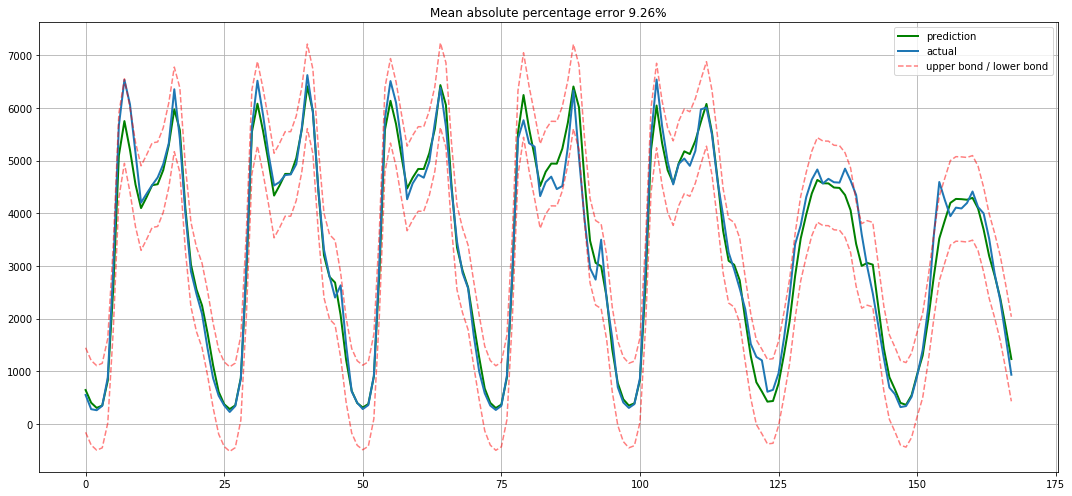

In [37]:
plotResults(baseline_predict.traffic_volume, plot_intervals=True, plot_anomalies=False)

## 4.4 Holt-Winters

In [38]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [39]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24*7):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series =values[train],
                            slen   =slen, 
                            alpha  =alpha,
                            beta   =beta,
                            gamma  =gamma,
                            n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [40]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(y_test.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

In [41]:
%%time
data_hw = data_ml.traffic_volume[-336:]#-7*2*24]
# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore,
               x0       =x, 
               args     =(data_ml.traffic_volume[-336*9:-336*2], mean_squared_error), 
               method   ="TNC", 
               bounds   = ((0, 1), (0, 1), (0, 1))
              )

Wall time: 15.9 s


In [42]:
slen = 24*7
# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data_hw,
                    slen           = slen       , 
                    alpha          = alpha_final, 
                    beta           = beta_final , 
                    gamma          = gamma_final, 
                    n_preds        = 0         ,
                    scaling_factor = 3           )
model.triple_exponential_smoothing()

0.0010344049257143273 0.023439617850447403 0.8694806729384515


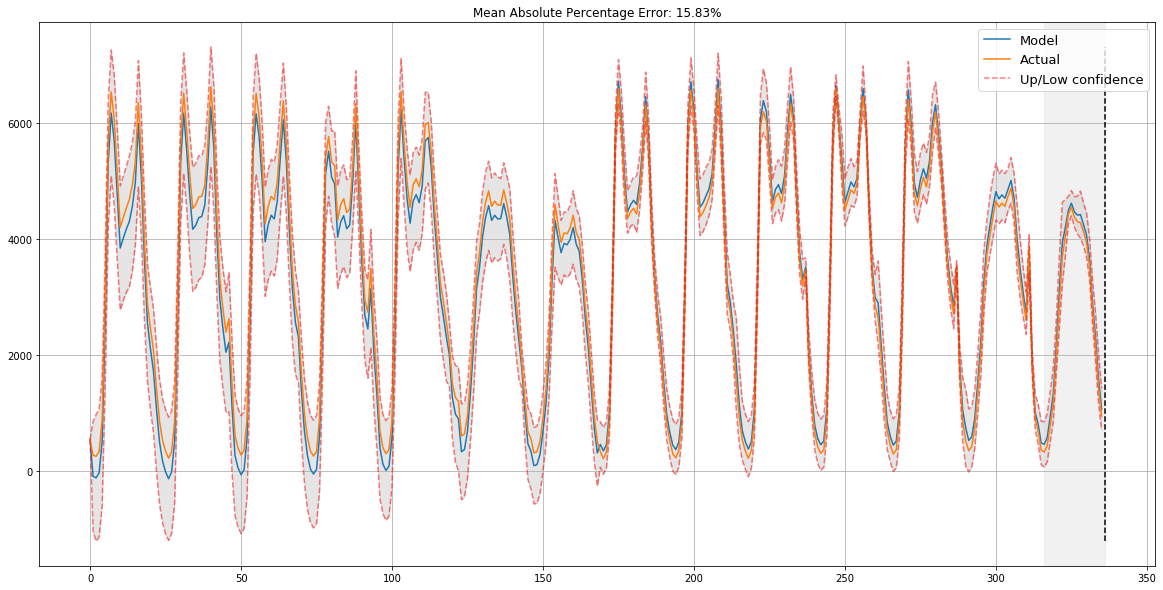

In [43]:
plotHoltWinters(data_hw, plot_intervals=True)

## 4.5 Regression Model

In [44]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [45]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [46]:
ridge = RidgeCV(cv=tscv, alphas=np.linspace(0.001, 0.01))
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([0.001     , 0.00118367, 0.00136735, 0.00155102, 0.00173469,
       0.00191837, 0.00210204, 0.00228571, 0.00246939, 0.00265306,
       0.00283673, 0.00302041, 0.00320408, 0.00338776, 0.00357143,
       0.0037551 , 0.00393878, 0.00412245, 0.00430612, 0.0044898 ,
       0.00467347, 0.00485714, 0.00504082, 0.00522449, 0.00540816,
       0.00559184, 0.00577551, 0.00595918, 0.00614286, 0.00632653,
       0.0065102 , 0.00669388, 0.00687755, 0.00706122, 0.0072449 ,
       0.00742857, 0.00761224, 0.00779592, 0.00797959, 0.00816327,
       0.00834694, 0.00853061, 0.00871429, 0.00889796, 0.00908163,
       0.00926531, 0.00944898, 0.00963265, 0.00981633, 0.01      ]),
        cv=TimeSeriesSplit(max_train_size=None, n_splits=5), fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

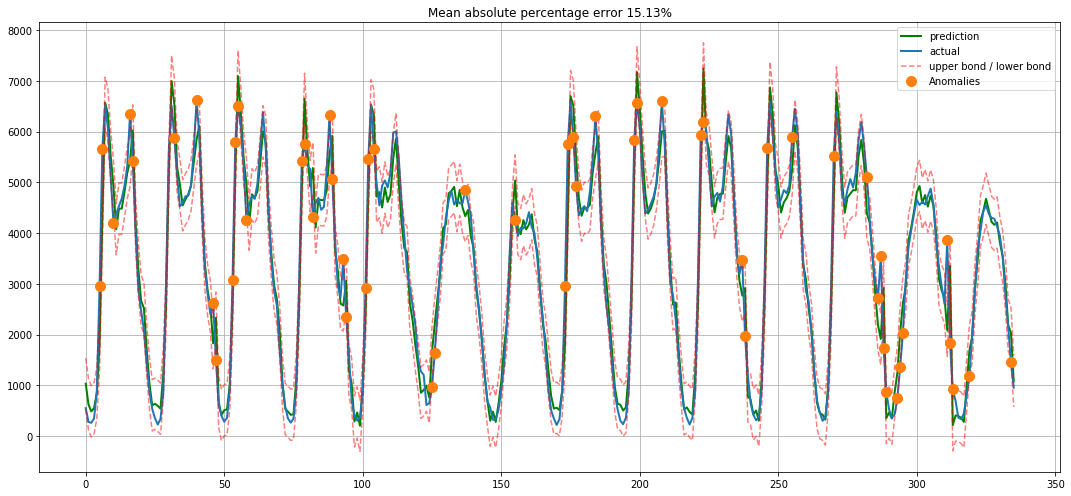

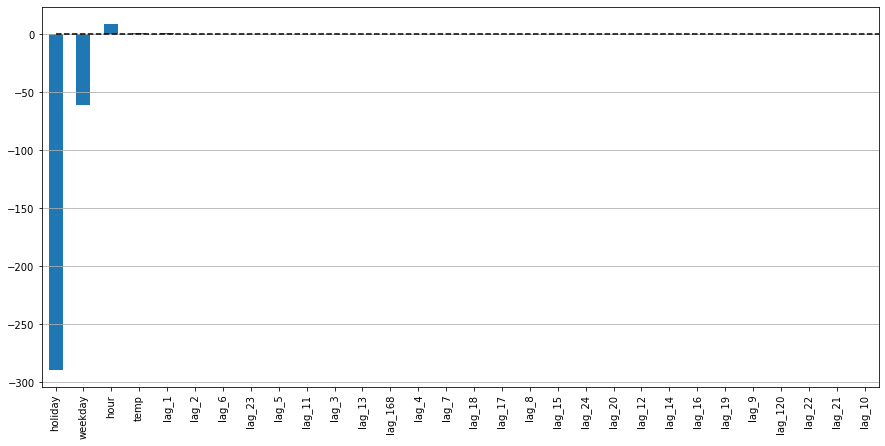

In [47]:
plotModelResults(ridge, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

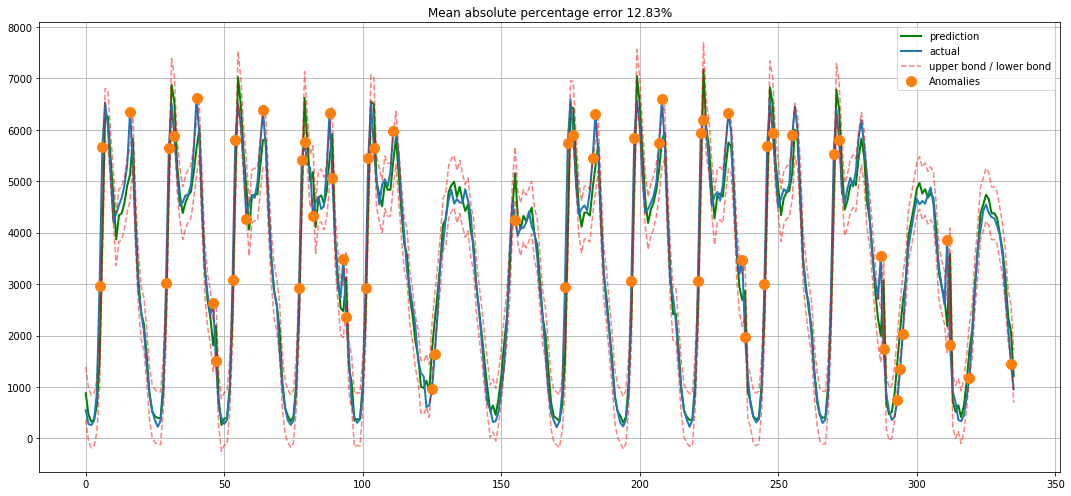

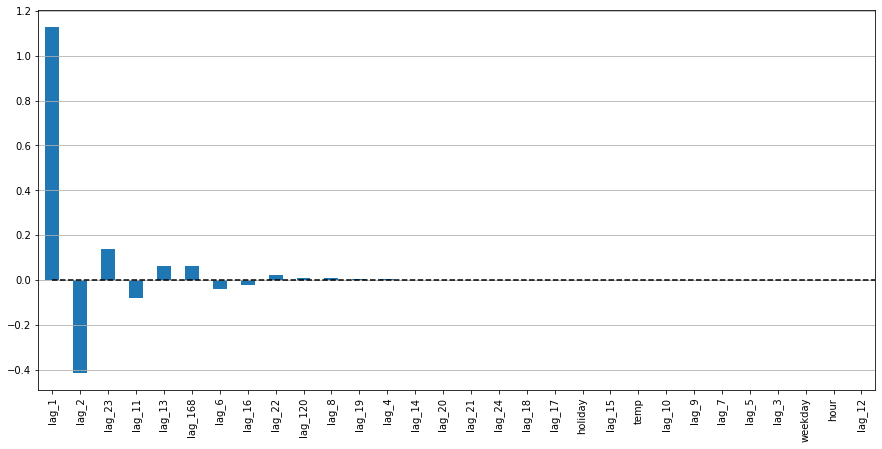

In [48]:
lasso = LassoCV(cv=tscv, eps=0.005)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

## 4.6 SARIMA Model

In [49]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method="ols")
        plt.tight_layout()

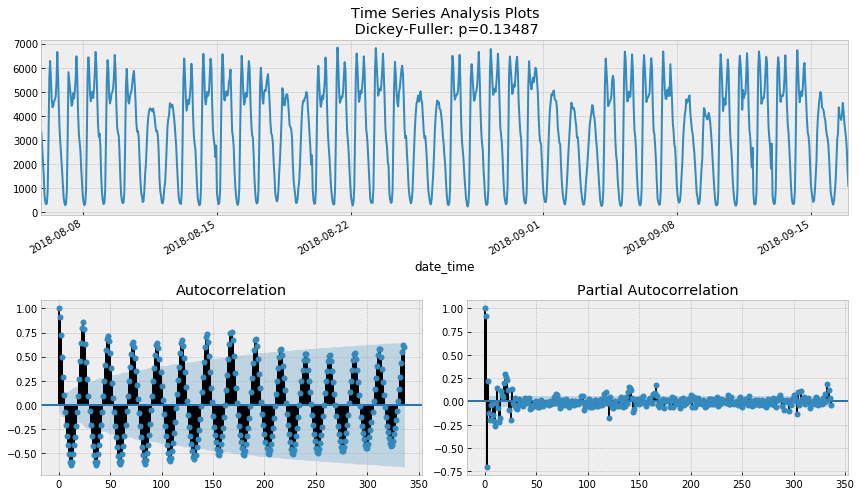

In [50]:
data_sarima = data_ml.traffic_volume[-7*24*8:-7*24*2].copy()
tsplot(data_sarima, lags=24*7*2)

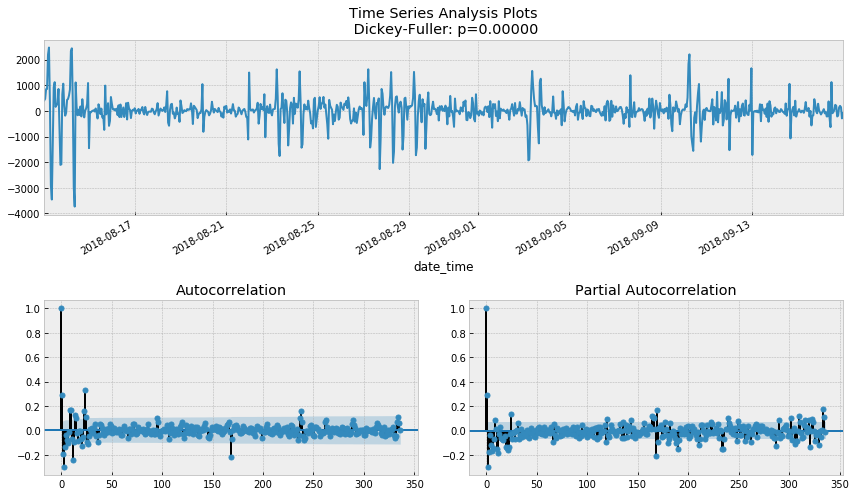

In [51]:
data_sarima_diff = data_sarima - data_sarima.shift(168)
#data_sarima_diff = data_sarima_diff - data_sarima_diff.shift(24)
data_sarima_diff = data_sarima_diff - data_sarima_diff.shift(1)
tsplot(data_sarima_diff[24*7+1+1:], lags=24*7*2)

In [52]:
# setting initial values and some bounds for them
ps = 2
d  = 1 
qs = 3
Ps = 1
D  = 1 
Qs = 1
s = 24*7

# creating list with all the possible combinations of parameters
#parameters = product(ps, qs, Ps, Qs)
#parameters_list = list(parameters)
#len(parameters_list)

In [53]:
# set the parameters that give the lowest AIC
p, q, P, Q = [2, 3, 1, 1]#result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(data_sarima,
                                     order=(p, d, q), 
                                     seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                      traffic_volume   No. Observations:                 1008
Model:             SARIMAX(2, 1, 3)x(1, 1, 1, 168)   Log Likelihood               -6267.369
Date:                             Wed, 24 Jun 2020   AIC                          12550.738
Time:                                     11:37:12   BIC                          12588.596
Sample:                                          0   HQIC                         12565.248
                                            - 1008                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6117      0.133      4.607      0.000       0.351       0.872
ar.L2         -0.1291      

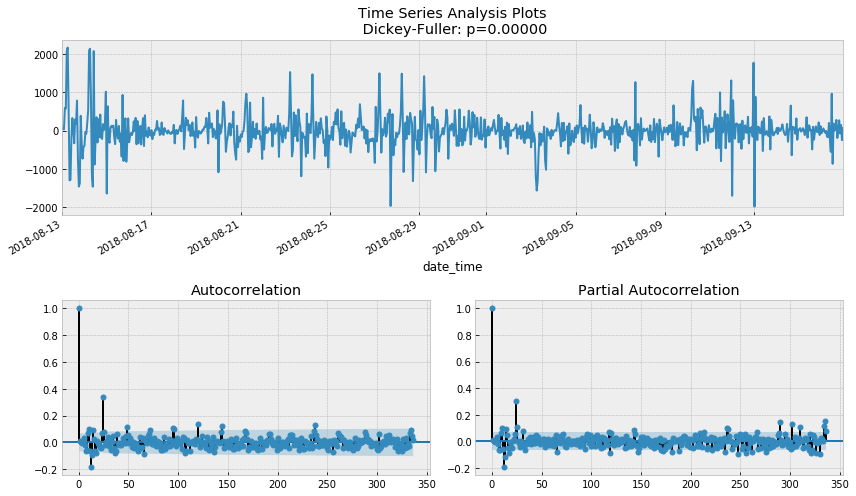

In [148]:
tsplot(best_model.resid[24*7+1:], lags=24*7*2)

In [151]:
def plotSARIMAtest(series, model, n_steps, s=24*7, d=1, plot_intervals=True, alpha=0.2):
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    forecast = model.get_forecast(steps=n_steps)
    model_predictions = (forecast.predicted_mean)
    data['arima_model'] = model_predictions.values[:len(series)]
    data.reset_index(drop=True, inplace=True)
    #
    error = mean_absolute_percentage_error(data['actual'], data['arima_model'])
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    
    plt.plot(model_predictions.values, color='r', label="model")
    #plt.plot(data.arima_model, label="actual")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        intervals.reset_index(drop=True, inplace=True)
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'], 
                         y2=intervals['lower'], alpha=0.2, color = "grey")    
    
    
    plt.legend()
    plt.grid(True);
    return data#.reset_index(drop=True, inplace=True)

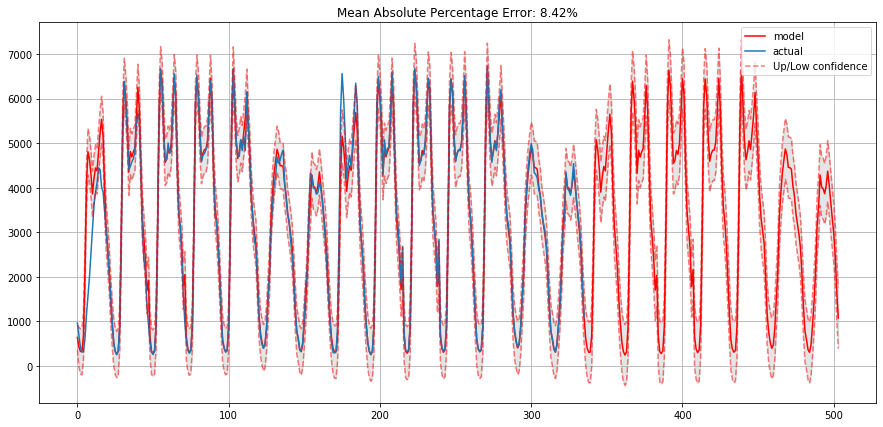

In [152]:
data = plotSARIMAtest(pd.DataFrame(data_sarima.reset_index(drop=True)[-24*7*2:]), best_model, 24*7*3, alpha=0.5)

# 6 Conclusion

Mean Absolute Percentage Error:
* Baseline 9.26 %  
* Holt-Winters 13.49%  
* Regression 12.83%  
* **SARIMA 8.42 %**  

Действительно, SARIMA лучше всего предсказывает поведение временного ряда, но она очень долго считается. Если бы я еще покрутил параметры SARIMA модели, то результат, я думаю, был бы еще лучше.